In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.7 MB/s eta 0:00:00


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests as gct
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
from google.colab import drive

In [ ]:
# Import pmdarima library
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import model_selection
from statistics import mean
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/blockchain'
os.chdir(path)

Mounted at /content/drive/


### 1. Our CSVs

In [ ]:
blocks = pd.read_csv('./blocks.csv')
blocks

,block_number,date_time,size,gas_limit,gas_used,transaction_count
0,13432144,2021-10-17 00:00,137337,30000000,29989466,395
1,13432145,2021-10-17 00:00,152246,30000000,29991025,350
2,13432146,2021-10-17 00:00,86607,30000000,18441422,182
3,13432147,2021-10-17 00:01,25291,29970705,5773702,44
4,13432148,2021-10-17 00:01,131885,29999972,26063490,337
...,...,...,...,...,...,...
5512332,18944476,2024-01-05 23:59,78795,30000000,29997771,177
5512333,18944477,2024-01-05 23:59,76583,30000000,15833654,168
5512334,18944478,2024-01-05 23:59,98769,30000000,11467724,113
5512335,18944479,2024-01-05 23:59,192081,30000000,16086918,114


In [ ]:
trans = pd.read_csv('./transcations.csv')
trans

,block_number,date_time,total_volume
0,13432144,2021-10-17 00:00,683.326345
1,13432145,2021-10-17 00:00,199.728254
2,13432146,2021-10-17 00:00,3046.571869
3,13432147,2021-10-17 00:01,142.073001
4,13432148,2021-10-17 00:01,320.793757
...,...,...,...
5452703,18944476,2024-01-05 23:59,44.329264
5452704,18944477,2024-01-05 23:59,58.734846
5452705,18944478,2024-01-05 23:59,8.849958
5452706,18944479,2024-01-05 23:59,16.469168


In [ ]:
df = pd.merge(blocks, trans, on=['block_number','date_time'], how='left')
df

,block_number,date_time,size,gas_limit,gas_used,transaction_count,total_volume
0,13432144,2021-10-17 00:00,137337,30000000,29989466,395,683.326345
1,13432145,2021-10-17 00:00,152246,30000000,29991025,350,199.728254
2,13432146,2021-10-17 00:00,86607,30000000,18441422,182,3046.571869
3,13432147,2021-10-17 00:01,25291,29970705,5773702,44,142.073001
4,13432148,2021-10-17 00:01,131885,29999972,26063490,337,320.793757
...,...,...,...,...,...,...,...
5512332,18944476,2024-01-05 23:59,78795,30000000,29997771,177,44.329264
5512333,18944477,2024-01-05 23:59,76583,30000000,15833654,168,58.734846
5512334,18944478,2024-01-05 23:59,98769,30000000,11467724,113,8.849958
5512335,18944479,2024-01-05 23:59,192081,30000000,16086918,114,16.469168


In [ ]:
df.dtypes

block_number           int64
date_time             object
size                   int64
gas_limit              int64
gas_used               int64
transaction_count      int64
total_volume         float64
dtype: object

In [ ]:
df.fillna(0, inplace=True)
df.sort_values(by='block_number', inplace=True)
df.drop(columns='block_number', inplace=True)
df['date_time'] = pd.to_datetime(blocks['date_time'].str[:16])
df.set_index('date_time', inplace=True)
by_day = df.resample('D').mean()
by_day.columns = ['avg_size','avg_gas_limit','avg_gas_used','avg_transaction_count', 'avg_transferred_eth']

In [ ]:
# 1-period lag
by_day['avg_gas_used_lag1'] = by_day['avg_gas_used'].shift(1)
by_day['avg_transaction_count_lag1'] = by_day['avg_transaction_count'].shift(1)

# rolling average of the past 7 days
by_day['avg_gas_used_rolling6'] = by_day['avg_gas_used'].rolling(window=7).mean()
by_day['vg_transaction_count_rolling6'] = by_day['avg_transaction_count'].rolling(window=7).mean()

by_day.dropna(inplace=True)

In [ ]:

by_day.reset_index(inplace=True)
by_day.rename(columns={'index': 'date_time'}, inplace=True)
by_day

,date_time,avg_size,avg_gas_limit,avg_gas_used,avg_transaction_count,avg_transferred_eth,avg_gas_used_lag1,avg_transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6
0,2021-10-23,72291.795054,3.002474e+07,1.545689e+07,194.576087,200.611032,1.545113e+07,195.920137,1.544343e+07,192.512938
1,2021-10-24,71576.064318,3.002441e+07,1.544829e+07,198.350684,151.453354,1.545689e+07,194.576087,1.544383e+07,195.248929
2,2021-10-25,71494.138984,3.002518e+07,1.545153e+07,202.476628,246.115634,1.544829e+07,198.350684,1.544675e+07,197.084841
3,2021-10-26,69812.711413,3.002491e+07,1.544777e+07,209.661989,263.749042,1.545153e+07,202.476628,1.544849e+07,199.452193
4,2021-10-27,69414.243499,3.002618e+07,1.544270e+07,215.997478,439.401969,1.544777e+07,209.661989,1.544730e+07,201.982949
...,...,...,...,...,...,...,...,...,...,...
800,2024-01-01,172255.595047,2.999972e+07,1.511294e+07,154.983115,132.993246,1.510753e+07,148.795853,1.509921e+07,156.574667
801,2024-01-02,175613.360713,2.999970e+07,1.509108e+07,158.474726,208.660422,1.511294e+07,154.983115,1.509829e+07,156.882294
802,2024-01-03,162254.063824,2.999971e+07,1.511663e+07,153.208024,235.214576,1.509108e+07,158.474726,1.510088e+07,155.903871
803,2024-01-04,159506.507155,2.999970e+07,1.507971e+07,156.646044,200.169137,1.511663e+07,153.208024,1.509890e+07,154.522298


In [ ]:
#In order to predict tomorrow we need to lag it such that we can have tomorrow's gas used in today's row
by_day['avg_gas_used_tom'] = by_day['avg_gas_used'].shift(-1)
by_day.dropna(inplace=True)
by_day

,date_time,avg_size,avg_gas_limit,avg_gas_used,avg_transaction_count,avg_transferred_eth,avg_gas_used_lag1,avg_transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6,avg_gas_used_tom
0,2021-10-23,72291.795054,3.002474e+07,1.545689e+07,194.576087,200.611032,1.545113e+07,195.920137,1.544343e+07,192.512938,1.544829e+07
1,2021-10-24,71576.064318,3.002441e+07,1.544829e+07,198.350684,151.453354,1.545689e+07,194.576087,1.544383e+07,195.248929,1.545153e+07
2,2021-10-25,71494.138984,3.002518e+07,1.545153e+07,202.476628,246.115634,1.544829e+07,198.350684,1.544675e+07,197.084841,1.544777e+07
3,2021-10-26,69812.711413,3.002491e+07,1.544777e+07,209.661989,263.749042,1.545153e+07,202.476628,1.544849e+07,199.452193,1.544270e+07
4,2021-10-27,69414.243499,3.002618e+07,1.544270e+07,215.997478,439.401969,1.544777e+07,209.661989,1.544730e+07,201.982949,1.544423e+07
...,...,...,...,...,...,...,...,...,...,...,...
799,2023-12-31,166562.542525,2.999978e+07,1.510753e+07,148.795853,123.778499,1.509966e+07,153.473973,1.509711e+07,156.602490,1.511294e+07
800,2024-01-01,172255.595047,2.999972e+07,1.511294e+07,154.983115,132.993246,1.510753e+07,148.795853,1.509921e+07,156.574667,1.509108e+07
801,2024-01-02,175613.360713,2.999970e+07,1.509108e+07,158.474726,208.660422,1.511294e+07,154.983115,1.509829e+07,156.882294,1.511663e+07
802,2024-01-03,162254.063824,2.999971e+07,1.511663e+07,153.208024,235.214576,1.509108e+07,158.474726,1.510088e+07,155.903871,1.507971e+07


In [ ]:
#Interest Rates CSV
rates = pd.read_csv('./long_term_rates_2000_2023.csv')
rates.drop('Extrapolation Factor', axis=1, inplace=True)

In [ ]:
rates['Date'] = pd.to_datetime(rates['Date'])
rates.rename(columns={'LT COMPOSITE (>10 Yrs)': 'Interest_rate'}, inplace=True)
rates

<ipython-input-14-5c2dd521ba98>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rates['Date'] = pd.to_datetime(rates['Date'])


,Date,Interest_rate,TREASURY 20-Yr CMT
0,2023-12-29,4.15,4.20
1,2023-12-28,4.09,4.14
2,2023-12-27,4.06,4.10
3,2023-12-26,4.17,4.20
4,2023-12-22,4.18,4.21
...,...,...,...
5998,2000-01-07,6.77,6.82
5999,2000-01-06,6.81,6.86
6000,2000-01-05,6.89,6.95
6001,2000-01-04,6.78,6.84


In [ ]:
df = pd.merge(by_day, rates, how='right', left_on='date_time', right_on='Date')
#df.set_index('date_time', inplace=True)
df.sort_values(by='Date', inplace=True)
df.dropna(inplace=True)
df.drop('Date', axis=1, inplace=True)

df

,date_time,avg_size,avg_gas_limit,avg_gas_used,avg_transaction_count,avg_transferred_eth,avg_gas_used_lag1,avg_transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6,avg_gas_used_tom,Interest_rate,TREASURY 20-Yr CMT
545,2021-10-25,71494.138984,3.002518e+07,1.545153e+07,202.476628,246.115634,1.544829e+07,198.350684,1.544675e+07,197.084841,1.544777e+07,2.03,2.07
544,2021-10-26,69812.711413,3.002491e+07,1.544777e+07,209.661989,263.749042,1.545153e+07,202.476628,1.544849e+07,199.452193,1.544270e+07,1.99,2.03
543,2021-10-27,69414.243499,3.002618e+07,1.544270e+07,215.997478,439.401969,1.544777e+07,209.661989,1.544730e+07,201.982949,1.544423e+07,1.89,1.93
542,2021-10-28,67421.642166,3.002487e+07,1.544423e+07,235.721286,282.674664,1.544270e+07,215.997478,1.544893e+07,207.529184,1.544402e+07,1.92,1.98
541,2021-10-29,64129.096891,3.002177e+07,1.544402e+07,228.695509,468.680630,1.544423e+07,235.721286,1.544792e+07,212.211380,1.544558e+07,1.91,1.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2023-12-22,157152.837050,2.999968e+07,1.508977e+07,169.080353,308.952772,1.508273e+07,173.852604,1.511023e+07,162.894603,1.510166e+07,4.18,4.21
3,2023-12-26,168868.433772,2.999971e+07,1.509749e+07,156.321339,232.276084,1.509825e+07,155.177878,1.509810e+07,163.901048,1.509850e+07,4.17,4.20
2,2023-12-27,173258.384778,2.999977e+07,1.509850e+07,160.056978,236.451383,1.509749e+07,156.321339,1.509531e+07,161.741618,1.509356e+07,4.06,4.10
1,2023-12-28,150761.920174,2.999976e+07,1.509356e+07,166.317059,257.944678,1.509850e+07,160.056978,1.509686e+07,160.665112,1.508478e+07,4.09,4.14


### 2. Plot data

In [ ]:
# download cryptocurrency data
btc = yf.download('BTC-USD', start='2021-08-06', end='2023-12-31')
eth = yf.download('ETH-USD', start='2021-08-06', end='2023-12-29')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
btc.reset_index(inplace=True)
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-08-06,40865.867188,43271.660156,39932.179688,42816.500000,42816.500000,38226483046
1,2021-08-07,42832.796875,44689.859375,42618.566406,44555.800781,44555.800781,40030862141
2,2021-08-08,44574.437500,45282.351562,43331.910156,43798.117188,43798.117188,36302664750
3,2021-08-09,43791.925781,46456.832031,42848.687500,46365.402344,46365.402344,38734079049
4,2021-08-10,46280.847656,46637.988281,44705.554688,45585.031250,45585.031250,33546019517


In [ ]:
eth.reset_index(inplace=True)
eth.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-08-06,2827.503418,2944.903320,2727.792725,2890.941650,2890.941650,26528577879
1,2021-08-07,2891.707520,3170.229736,2868.535645,3157.238770,3157.238770,33081467129
2,2021-08-08,3161.232666,3184.604004,2951.747314,3013.732666,3013.732666,28433638008
3,2021-08-09,3012.885742,3185.701172,2900.926025,3167.856201,3167.856201,31983260936
4,2021-08-10,3163.050049,3228.940674,3059.229004,3141.691162,3141.691162,27605221710


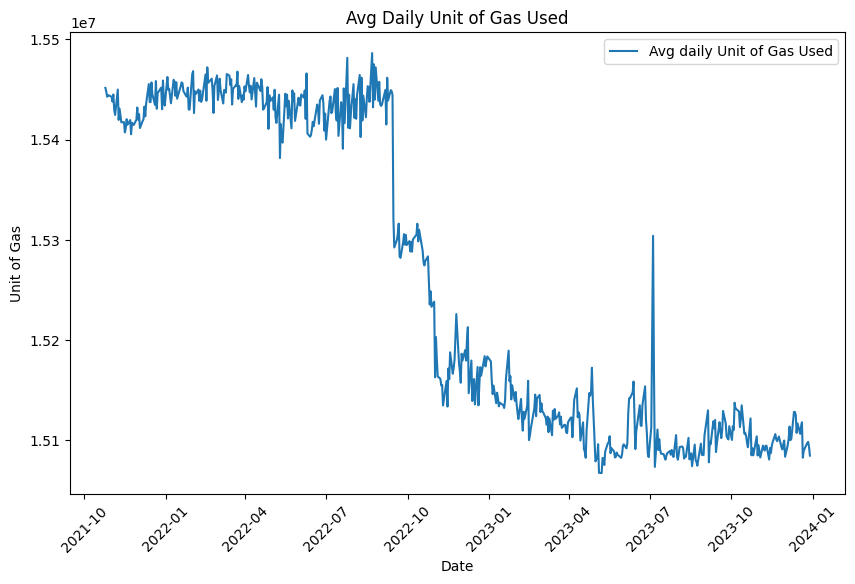

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['date_time'], df['avg_gas_used'], label='Avg daily Unit of Gas Used')  # Assuming date_time is the index
plt.title('Avg Daily Unit of Gas Used')
plt.xlabel('Date')
plt.ylabel('Unit of Gas')
plt.legend()
plt.xticks(rotation=45)
plt.show()

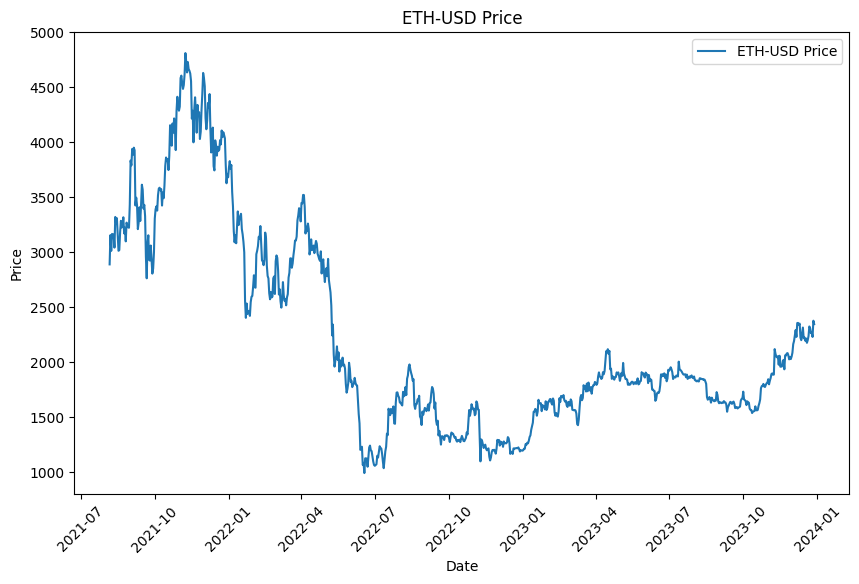

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(eth['Date'], eth['Adj Close'], label='ETH-USD Price')  # Assuming the date is the index for eth
plt.title('ETH-USD Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

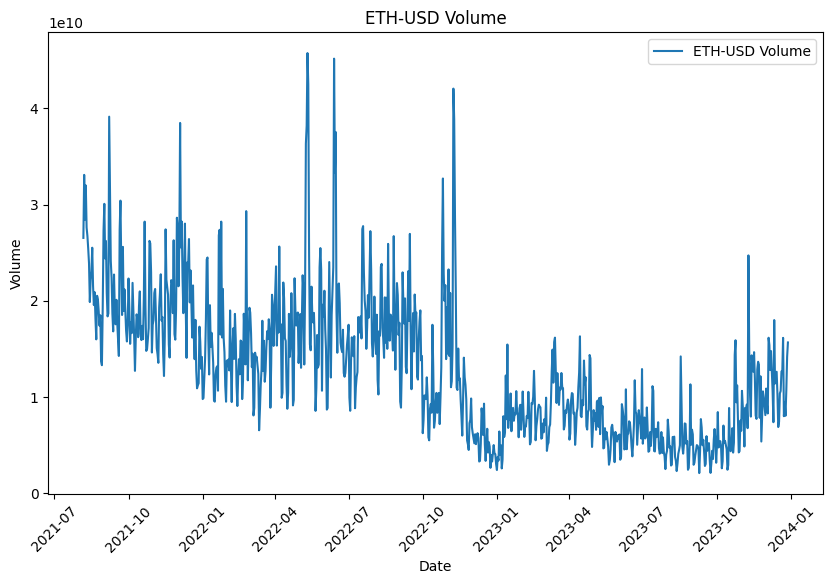

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(eth['Date'], eth['Volume'], label='ETH-USD Volume')  # Assuming the date is the index for eth
plt.title('ETH-USD Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.xticks(rotation=45)
plt.show()

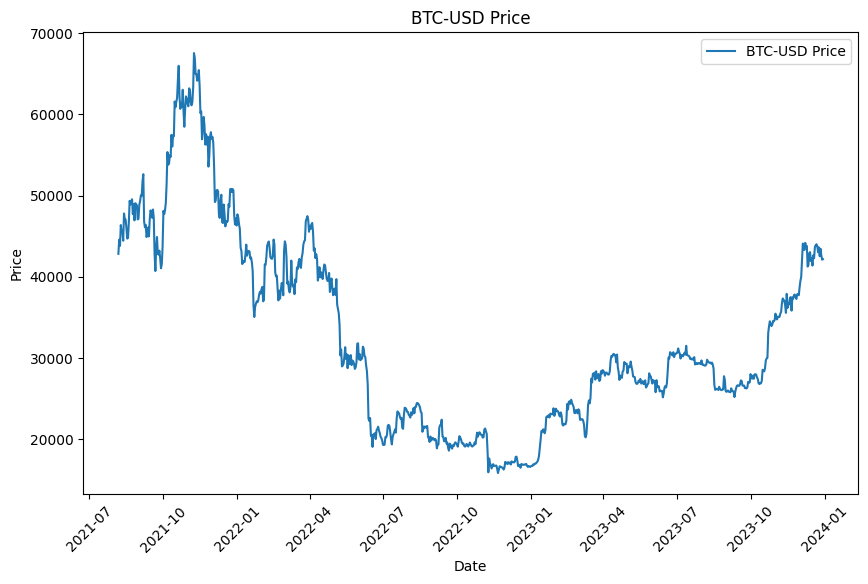

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(btc['Date'], btc['Adj Close'], label='BTC-USD Price')  # Assuming the date is the index for btc
plt.title('BTC-USD Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

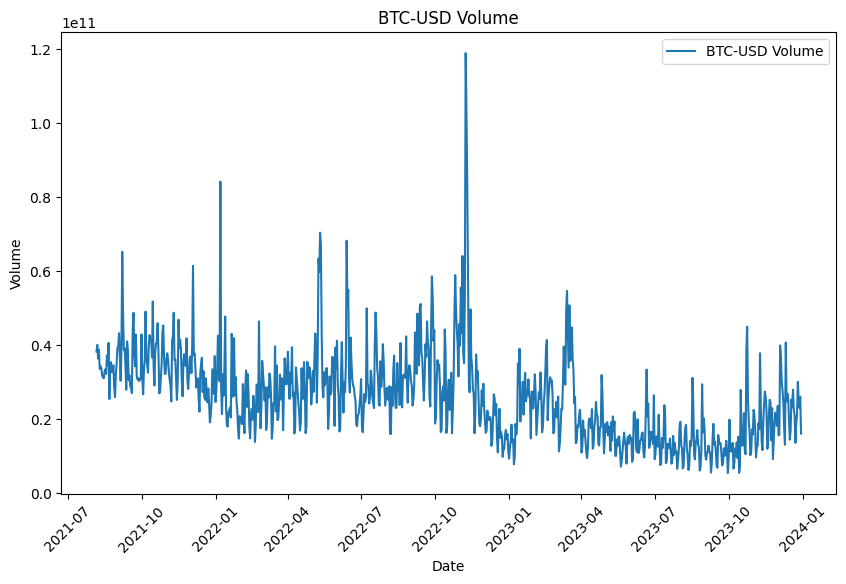

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(btc['Date'], btc['Volume'], label='BTC-USD Volume')  # Assuming the date is the index for btc
plt.title('BTC-USD Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.xticks(rotation=45)
plt.show()

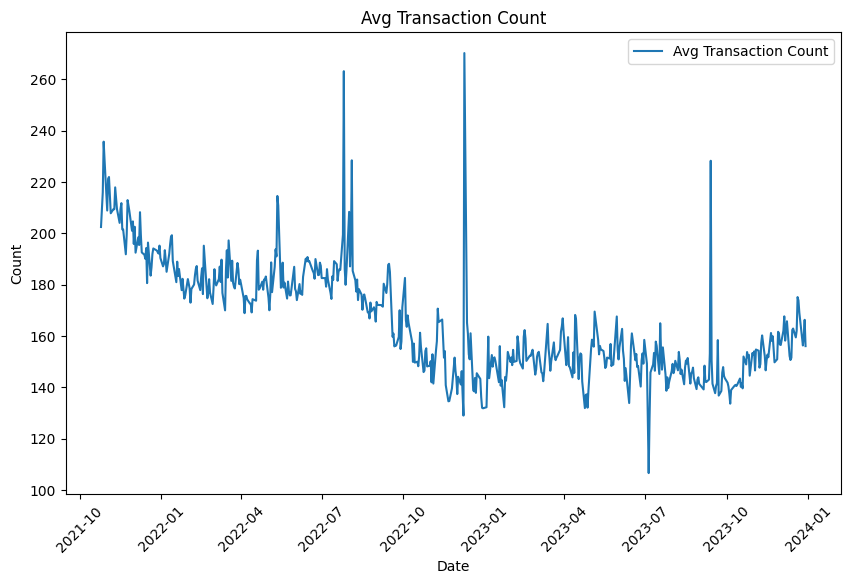

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['date_time'], df['avg_transaction_count'], label='Avg Transaction Count')  # Assuming date_time is the index
plt.title('Avg Transaction Count')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.show()

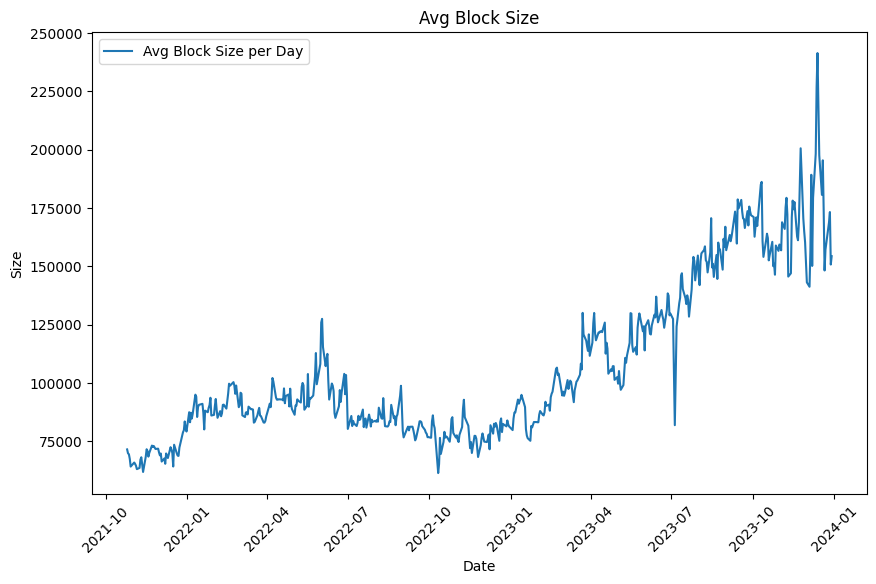

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['date_time'], df['avg_size'], label='Avg Block Size per Day')  # Assuming date_time is the index
plt.title('Avg Block Size')
plt.xlabel('Date')
plt.ylabel('Size')
plt.legend()
plt.xticks(rotation=45)
plt.show()

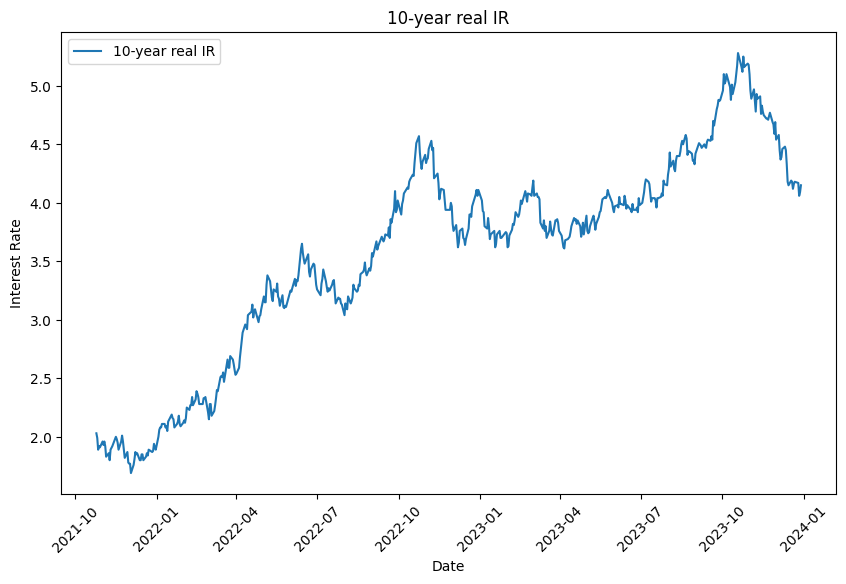

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['date_time'], df['Interest_rate'], label='10-year real IR')  # Assuming date_time is the index
plt.title('10-year real IR')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### 3. Merge All CSVs

In [ ]:
#Merge df & Eth Together
eth_renamed = eth.rename(columns={col: col + '_eth' if col != 'Date' else col for col in eth.columns})

df_plus_eth = pd.merge(df, eth_renamed, how='left', left_on='date_time', right_on='Date')

df_plus_eth

,date_time,avg_size,avg_gas_limit,avg_gas_used,avg_transaction_count,avg_transferred_eth,avg_gas_used_lag1,avg_transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6,avg_gas_used_tom,Interest_rate,TREASURY 20-Yr CMT,Date,Open_eth,High_eth,Low_eth,Close_eth,Adj Close_eth,Volume_eth
0,2021-10-25,71494.138984,3.002518e+07,1.545153e+07,202.476628,246.115634,1.544829e+07,198.350684,1.544675e+07,197.084841,1.544777e+07,2.03,2.07,2021-10-25,4084.425781,4236.666992,4072.034668,4217.876953,4217.876953,1.599573e+10
1,2021-10-26,69812.711413,3.002491e+07,1.544777e+07,209.661989,263.749042,1.545153e+07,202.476628,1.544849e+07,199.452193,1.544270e+07,1.99,2.03,2021-10-26,4217.337891,4289.131348,4106.823730,4131.102051,4131.102051,1.715771e+10
2,2021-10-27,69414.243499,3.002618e+07,1.544270e+07,215.997478,439.401969,1.544777e+07,209.661989,1.544730e+07,201.982949,1.544423e+07,1.89,1.93,2021-10-27,4132.173340,4299.152832,3930.257324,3930.257324,3930.257324,2.621953e+10
3,2021-10-28,67421.642166,3.002487e+07,1.544423e+07,235.721286,282.674664,1.544270e+07,215.997478,1.544893e+07,207.529184,1.544402e+07,1.92,1.98,2021-10-28,3924.815430,4293.150879,3905.706055,4287.318848,4287.318848,2.595815e+10
4,2021-10-29,64129.096891,3.002177e+07,1.544402e+07,228.695509,468.680630,1.544423e+07,235.721286,1.544792e+07,212.211380,1.544558e+07,1.91,1.98,2021-10-29,4288.686523,4455.735352,4271.707520,4414.746582,4414.746582,2.296764e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,2023-12-22,157152.837050,2.999968e+07,1.508977e+07,169.080353,308.952772,1.508273e+07,173.852604,1.511023e+07,162.894603,1.510166e+07,4.18,4.21,2023-12-22,2239.598145,2341.947510,2233.532715,2326.524902,2326.524902,1.613725e+10
542,2023-12-26,168868.433772,2.999971e+07,1.509749e+07,156.321339,232.276084,1.509825e+07,155.177878,1.509810e+07,163.901048,1.509850e+07,4.17,4.20,2023-12-26,2272.218750,2274.557373,2180.225342,2231.465332,2231.465332,1.066858e+10
543,2023-12-27,173258.384778,2.999977e+07,1.509850e+07,160.056978,236.451383,1.509749e+07,156.321339,1.509531e+07,161.741618,1.509356e+07,4.06,4.10,2023-12-27,2231.393066,2392.608643,2215.140381,2378.739990,2378.739990,1.416134e+10
544,2023-12-28,150761.920174,2.999976e+07,1.509356e+07,166.317059,257.944678,1.509850e+07,160.056978,1.509686e+07,160.665112,1.508478e+07,4.09,4.14,2023-12-28,2380.200684,2445.017578,2338.703857,2347.566162,2347.566162,1.566080e+10


In [ ]:
#Merge df_plus_eth & Bit Together
btc_renamed = btc.rename(columns={col: col + '_btc' if col != 'Date' else col for col in btc.columns})

df_all = pd.merge(df_plus_eth, btc_renamed, how='left', left_on='date_time', right_on='Date')

df_all

,date_time,avg_size,avg_gas_limit,avg_gas_used,avg_transaction_count,avg_transferred_eth,avg_gas_used_lag1,avg_transaction_count_lag1,avg_gas_used_rolling6,vg_transaction_count_rolling6,...,Close_eth,Adj Close_eth,Volume_eth,Date_y,Open_btc,High_btc,Low_btc,Close_btc,Adj Close_btc,Volume_btc
0,2021-10-25,71494.138984,3.002518e+07,1.545153e+07,202.476628,246.115634,1.544829e+07,198.350684,1.544675e+07,197.084841,...,4217.876953,4217.876953,1.599573e+10,2021-10-25,60893.925781,63729.324219,60691.800781,63039.824219,63039.824219,31064911614
1,2021-10-26,69812.711413,3.002491e+07,1.544777e+07,209.661989,263.749042,1.545153e+07,202.476628,1.544849e+07,199.452193,...,4131.102051,4131.102051,1.715771e+10,2021-10-26,63032.761719,63229.027344,59991.160156,60363.792969,60363.792969,34878965587
2,2021-10-27,69414.243499,3.002618e+07,1.544270e+07,215.997478,439.401969,1.544777e+07,209.661989,1.544730e+07,201.982949,...,3930.257324,3930.257324,2.621953e+10,2021-10-27,60352.000000,61435.183594,58208.187500,58482.386719,58482.386719,43657076893
3,2021-10-28,67421.642166,3.002487e+07,1.544423e+07,235.721286,282.674664,1.544270e+07,215.997478,1.544893e+07,207.529184,...,4287.318848,4287.318848,2.595815e+10,2021-10-28,58470.730469,62128.632812,58206.917969,60622.136719,60622.136719,45257083247
4,2021-10-29,64129.096891,3.002177e+07,1.544402e+07,228.695509,468.680630,1.544423e+07,235.721286,1.544792e+07,212.211380,...,4414.746582,4414.746582,2.296764e+10,2021-10-29,60624.871094,62927.609375,60329.964844,62227.964844,62227.964844,36856881767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,2023-12-22,157152.837050,2.999968e+07,1.508977e+07,169.080353,308.952772,1.508273e+07,173.852604,1.511023e+07,162.894603,...,2326.524902,2326.524902,1.613725e+10,2023-12-22,43868.988281,44367.957031,43441.968750,43997.902344,43997.902344,21028503216
542,2023-12-26,168868.433772,2.999971e+07,1.509749e+07,156.321339,232.276084,1.509825e+07,155.177878,1.509810e+07,163.901048,...,2231.465332,2231.465332,1.066858e+10,2023-12-26,43599.847656,43603.175781,41676.488281,42520.402344,42520.402344,30026850982
543,2023-12-27,173258.384778,2.999977e+07,1.509850e+07,160.056978,236.451383,1.509749e+07,156.321339,1.509531e+07,161.741618,...,2378.739990,2378.739990,1.416134e+10,2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
544,2023-12-28,150761.920174,2.999976e+07,1.509356e+07,166.317059,257.944678,1.509850e+07,160.056978,1.509686e+07,160.665112,...,2347.566162,2347.566162,1.566080e+10,2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014


### 4. Heatmap

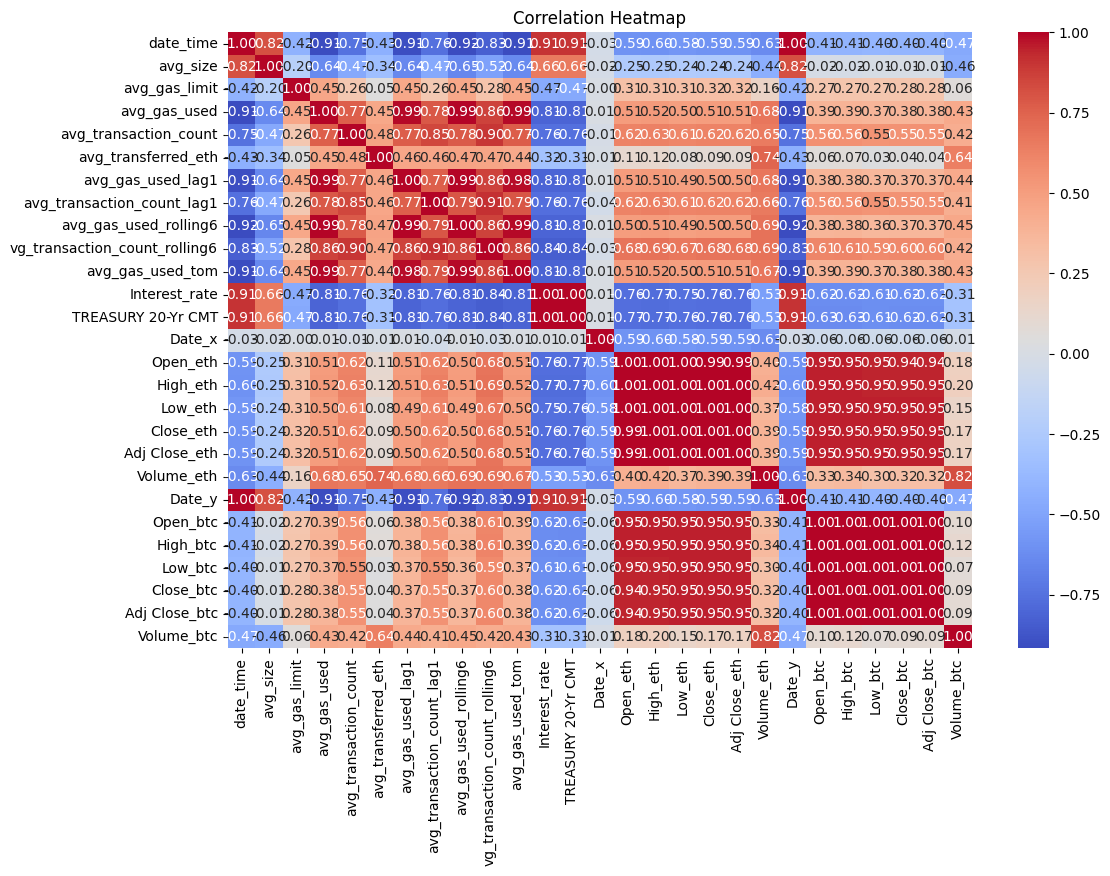

In [ ]:
# plot the correlation coefficient
correlation_matrix = df_all.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Set the title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

In [ ]:
df_all.columns

Index(['date_time', 'avg_size', 'avg_gas_limit', 'avg_gas_used',
       'avg_transaction_count', 'avg_transferred_eth', 'avg_gas_used_lag1',
       'avg_transaction_count_lag1', 'avg_gas_used_rolling6',
       'vg_transaction_count_rolling6', 'avg_gas_used_tom', 'Interest_rate',
       'TREASURY 20-Yr CMT', 'Date_x', 'Open_eth', 'High_eth', 'Low_eth',
       'Close_eth', 'Adj Close_eth', 'Volume_eth', 'Date_y', 'Open_btc',
       'High_btc', 'Low_btc', 'Close_btc', 'Adj Close_btc', 'Volume_btc'],
      dtype='object')

In [ ]:
df_all.set_index('date_time', inplace=True)


In [ ]:
df_all = df_all.drop(['Date_x', 'Date_y'], axis=1)

#### Linear Regression with Backtest

In [ ]:
#CORRECTED LINEAR REGRESSION W/ PRINT MIDWAY
import pandas as pd
import numpy as np
import statsmodels.api as sm

window_size = 30

actuals = []
predictions = []

# Loop through the DataFrame
for t in range(window_size, len(df_all)):
    # Define the training window
    train = df_all.iloc[t - window_size:t]

    # The independent variables (features) should exclude the target variable 'avg_gas_used'
    # This assumes all other columns are features. If not, select the appropriate columns
    X_train = train.drop(columns=['avg_gas_used_tom'])
    y_train = train['avg_gas_used_tom']

    # Add a constant to the model (the intercept term)
    X_train = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train).fit()

    # Prepare X_test for the next day, ensuring it is 2D and has the same structure as X_train
    test_features = df_all.iloc[t]  # Get the features for day t
    test_features = test_features.drop(labels=['avg_gas_used_tom'])  # Drop the target variable
    X_test = pd.DataFrame([test_features])  # Make it 2D
    X_test = sm.add_constant(X_test)  # Add the constant

    print(X_train)

Streaming output truncated to the last 5000 lines.
2023-10-20  28601.669922  29682.949219   29682.949219  21536125230  
2023-10-23  30097.828125  33086.234375   33086.234375  38363572311  
2023-10-24  32880.761719  33901.527344   33901.527344  44934999645  
2023-10-25  33709.109375  34502.820312   34502.820312  25254318008  
2023-10-26  33762.324219  34156.648438   34156.648438  19427195376  
2023-10-27  33416.886719  33909.800781   33909.800781  16418032871  
2023-10-30  34110.972656  34502.363281   34502.363281  17184860315  
2023-10-31  34083.308594  34667.781250   34667.781250  15758270810  
2023-11-01  34170.691406  35437.253906   35437.253906  22446272005  
2023-11-02  34401.574219  34938.242188   34938.242188  20998158544  
2023-11-03  34133.441406  34732.324219   34732.324219  17158456701  
2023-11-06  34765.363281  35037.371094   35037.371094  12693436420  
2023-11-07  34545.816406  35443.562500   35443.562500  18834737789  
2023-11-08  35147.800781  35655.277344   35655.27734

In [ ]:
#CORRECTED LINEAR REGRESSION
import pandas as pd
import numpy as np
import statsmodels.api as sm

window_size = 30

actuals = []
predictions = []

# Loop through the DataFrame
for t in range(window_size, len(df_all)):
    # Define the training window
    train = df_all.iloc[t - window_size:t-1] # t-1

    # The independent variables (features) should exclude the target variable 'avg_gas_used'
    # This assumes all other columns are features. If not, select the appropriate columns
    X_train = train.drop(columns=['avg_gas_used_tom'])
    y_train = train['avg_gas_used_tom']

    # Add a constant to the model (the intercept term)
    X_train = sm.add_constant(X_train)

    # Fit the model
    model = sm.OLS(y_train, X_train).fit()

    # Prepare X_test for the next day, ensuring it is 2D and has the same structure as X_train
    test_features = df_all.iloc[t]  # Get the features for day t
    test_features = test_features.drop(labels=['avg_gas_used_tom'])  # Drop the target variable
    X_test = pd.DataFrame([test_features])  # Make it 2D
    X_test = sm.add_constant(X_test, has_constant='add')  # Add the constant

    #print(X_test)

    # Predict the next day's avg_gas_used
    pred = model.predict(X_test)[0]
    # Store the actual and predicted values
    actual = df_all['avg_gas_used_tom'].iloc[t]  # Actual value for day t (actually need to use t+1)
    actuals.append(actual)
    predictions.append(pred)

# Now, actuals and predictions hold the actual and predicted values, respectively
# You can calculate performance metrics like MSE and R-squared here

# Import mean_squared_error and r2_score if not already imported
from sklearn.metrics import mean_squared_error, r2_score

actuals = actuals[:-1]
predictions = predictions[:-1]

mse = mean_squared_error(actuals, predictions) # double check Y_hat_t+1 and Y_t+1 are on the same row (row t), and drop nulls
r2 = r2_score(actuals, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 3543613505.6856484
R-squared: 0.8495568173676774


In [ ]:
pd.DataFrame(predictions).shift()

,0
0,NaN
1,1.543564e+07
2,1.542388e+07
3,1.545859e+07
4,1.544482e+07
...,...
511,1.507578e+07
512,1.507793e+07
513,1.504052e+07
514,1.511553e+07


In [ ]:
# X_t, Y_t+1
# t: X_t -> Y_hat_t+1 vs Y_t+1, on row t because you led the target

#### XGBRegressor

In [ ]:
df_all.dtypes

avg_size                         float64
avg_gas_limit                    float64
avg_gas_used                     float64
avg_transaction_count            float64
avg_transferred_eth              float64
avg_gas_used_lag1                float64
avg_transaction_count_lag1       float64
avg_gas_used_rolling6            float64
vg_transaction_count_rolling6    float64
avg_gas_used_tom                 float64
Interest_rate                    float64
TREASURY 20-Yr CMT               float64
Open_eth                         float64
High_eth                         float64
Low_eth                          float64
Close_eth                        float64
Adj Close_eth                    float64
Volume_eth                       float64
Open_btc                         float64
High_btc                         float64
Low_btc                          float64
Close_btc                        float64
Adj Close_btc                    float64
Volume_btc                         int64
dtype: object

In [ ]:
#With Correct Back Test
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Adjusting window size to 7 days as requested
window_size = 7

actuals = []
predictions = []

# Loop through the DataFrame
for t in range(window_size, len(df_all-1)):
    # Define the training window
    train = df_all.iloc[t - window_size:t-1]

    # The independent variables (features) should exclude the target variable 'avg_gas_used_tom'
    X_train = train.drop(columns=['avg_gas_used_tom'])
    y_train = train['avg_gas_used_tom']

    # Initialize and fit the XGBoost model
    model = XGBRegressor()
    model.fit(X_train, y_train)

    # Prepare X_test for the next day, ensuring it has the same structure as X_train
    test_features = df_all.iloc[t]  # Get the features for day t
    X_test = test_features.drop(labels=['avg_gas_used_tom']).to_frame().T  # Drop target and convert to DataFrame

    # Predict the next day's avg_gas_used
    pred = model.predict(X_test)[0]

    # Store the actual and predicted values
    actual = df_all['avg_gas_used_tom'].iloc[t]
    actuals.append(actual)
    predictions.append(pred)

actuals = actuals[:-1]
predictions = predictions[:-1]

# Calculate performance metrics like MSE and R-squared
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 928294332.5312116
R-squared: 0.9608747889760948


#### Random Forest Regression

In [ ]:
#### With backtest

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Adjusting window size to 7 days as requested
window_size = 7

actuals = []
predictions = []

# Loop through the DataFrame
for t in range(window_size, len(df_all)-1):
    # Define the training window
    train = df_all.iloc[t - window_size:t]

    # The independent variables (features) should exclude the target variable 'avg_gas_used_tom'
    X_train = train.drop(columns=['avg_gas_used_tom'])
    y_train = train['avg_gas_used_tom']

    # Initialize and fit the Random Forest model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Prepare X_test for the next day, ensuring it has the same structure as X_train
    test_features = df_all.iloc[t]  # Get the features for day t
    X_test = test_features.drop(labels=['avg_gas_used_tom']).to_frame().T  # Drop target and convert to DataFrame

    # Predict the next day's avg_gas_used
    pred = model.predict(X_test)[0]

    # Store the actual and predicted values
    actual = df_all['avg_gas_used_tom'].iloc[t]
    actuals.append(actual)
    predictions.append(pred)

actuals = actuals[:-1]
predictions = predictions[:-1]

# Calculate performance metrics like MSE and R-squared
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 501309242.1223696
R-squared: 0.9788608182684762


#### K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Adjusting window size to 7 days as requested
window_size = 7

actuals = []
predictions = []

# Loop through the DataFrame
for t in range(window_size, len(df_all)-1):
    # Define the training window
    train = df_all.iloc[t - window_size:t]

    # The independent variables (features) should exclude the target variable 'avg_gas_used'
    X_train = train.drop(columns=['avg_gas_used_tom'])
    y_train = train['avg_gas_used_tom']

    # Initialize and fit the K-Nearest Neighbors model
    model = KNeighborsRegressor(n_neighbors=5)  # n_neighbors is a parameter you may want to tune
    model.fit(X_train, y_train)

    # Prepare X_test for the next day, ensuring it has the same structure as X_train
    test_features = df_all.iloc[t]  # Get the features for day t
    X_test = test_features.drop(labels=['avg_gas_used_tom']).to_frame().T  # Drop target and convert to DataFrame

    # Predict the next day's avg_gas_used
    pred = model.predict(X_test)[0]

    # Store the actual and predicted values
    actual = df_all['avg_gas_used_tom'].iloc[t]  # Actual value for day t+1
    actuals.append(actual)
    predictions.append(pred)

# Calculate performance metrics like MSE and R-squared
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 565821523.5943063
R-squared: 0.9761520826566605


#### Ridge Model

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Adjusting window size to 7 days as requested
window_size = 7

actuals = []
predictions = []

# Loop through the DataFrame
for t in range(window_size, len(df_all)-1):
    # Define the training window
    train = df_all.iloc[t - window_size:t]

    # The independent variables (features) should exclude the target variable 'avg_gas_used'
    X_train = train.drop(columns=['avg_gas_used'])
    y_train = train['avg_gas_used']

    # Initialize and fit the Ridge regression model
    model = Ridge(alpha=1.0)  # Alpha is a regularization parameter that you may tune
    model.fit(X_train, y_train)

    # Prepare X_test for the next day, ensuring it has the same structure as X_train
    test_features = df_all.iloc[t]  # Get the features for day t
    X_test = test_features.drop(labels=['avg_gas_used']).to_frame().T  # Drop target and convert to DataFrame

    # Predict the next day's avg_gas_used
    pred = model.predict(X_test)[0]

    # Store the actual and predicted values
    actual = df_all['avg_gas_used'].iloc[t+1]  # Actual value for day t+1
    actuals.append(actual)
    predictions.append(pred)

# Calculate performance metrics like MSE and R-squared
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=7.78833e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=8.04944e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", ov

Mean Squared Error: 6431590252.27084
R-squared: 0.7354483833035873


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.336e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=5.54959e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=4.01922e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=5.51645e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: Us

#### Arima Model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Adjusting window size to 7 days as requested
window_size = 7

actuals = []
predictions = []

# Loop through the DataFrame
for t in range(window_size, len(df_all)-1):
    # Define the training window
    train = df_all.iloc[t - window_size:t]

    # The target variable 'avg_gas_used'
    y_train = train['avg_gas_used']

    # Initialize and fit the ARIMA model
    # Assuming an ARIMA(1,1,1) model; you might need to optimize the order (p,d,q) based on your data
    model = ARIMA(y_train, order=(1,1,1))
    model_fit = model.fit()

    # Predict the next day's avg_gas_used
    pred = model_fit.forecast()[0]

    # Store the actual and predicted values
    actual = df_all['avg_gas_used'].iloc[t+1]  # Actual value for day t+1
    actuals.append(actual)
    predictions.append(pred)

# Calculate performance metrics like MSE
mse = mean_squared_error(actuals, predictions)

print(f'Mean Squared Error: {mse}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be

KeyError: 0

#### Transformers

In [ ]:
from transformers import pipeline

classifier = pipeline(task = "time-series-foundation-models/Lag-Llama")

classifier

KeyError: "Unknown task time-series-foundation-models/Lag-Llama, available tasks are ['audio-classification', 'automatic-speech-recognition', 'conversational', 'depth-estimation', 'document-question-answering', 'feature-extraction', 'fill-mask', 'image-classification', 'image-feature-extraction', 'image-segmentation', 'image-to-image', 'image-to-text', 'mask-generation', 'ner', 'object-detection', 'question-answering', 'sentiment-analysis', 'summarization', 'table-question-answering', 'text-classification', 'text-generation', 'text-to-audio', 'text-to-speech', 'text2text-generation', 'token-classification', 'translation', 'video-classification', 'visual-question-answering', 'vqa', 'zero-shot-audio-classification', 'zero-shot-classification', 'zero-shot-image-classification', 'zero-shot-object-detection', 'translation_XX_to_YY']"

In [ ]:
from transformers import pipeline

model_name = "time-series-foundation-models/Lag-Llama"

classifier = pipeline(task = "predict tomorrow", model = model_name)

classifier

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


OSError: time-series-foundation-models/Lag-Llama does not appear to have a file named config.json. Checkout 'https://huggingface.co/time-series-foundation-models/Lag-Llama/main' for available files.

In [ ]:
from transformers import AutoformerConfig, AutoformerModel

# Initializing a default Autoformer configuration
configuration = AutoformerConfig()

# Randomly initializing a model (with random weights) from the configuration
model = AutoformerModel(configuration)

# Accessing the model configuration
configuration = model.config

ValueError: The `prediction_length` config needs to be specified.

In [ ]:
from huggingface_hub import hf_hub_download
import torch
from transformers import AutoformerModel

file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

model = AutoformerModel.from_pretrained("huggingface/autoformer-tourism-monthly")

# during training, one provides both past and future values
# as well as possible additional features
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
)

last_hidden_state = outputs.last_hidden_state

#### Disregard below it is incorrect

### 5. OLS Regression Analysis with Backtest

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score

# Define the formula
formula = 'avg_gas_used ~ avg_size + avg_gas_limit + avg_transaction_count + avg_transferred_eth + avg_gas_used_lag1 + avg_transaction_count_lag1 + avg_gas_used_rolling6 + vg_transaction_count_rolling6 + Interest_rate + Close_eth + Volume_eth + Close_btc + Volume_btc'

# Initialize lists for actual values and predictions
actuals = []
predictions = []

# Define the window size for the rolling prediction
window_size = 30

# Rolling prediction
for end in range(window_size, len(df_all)):
    # Define the training data up to the current point
    train_data = df_all.iloc[:end]
    # The current point to predict
    test_data = df_all.iloc[end:end+1]

    if test_data.isnull().values.any():
        # Skip this iteration if there are NaN values in the test_data
        continue

    # Fit the model on the training data
    model_eth = smf.ols(formula=formula, data=train_data.dropna()).fit()

    # Predict the current day
    pred = model_eth.predict(test_data)

    # Check if pred is NaN
    if not np.isnan(pred.values[0]):
        predictions.append(pred.values[0])
        actuals.append(test_data['avg_gas_used'].values[0])

# Ensure actuals and predictions lists are not empty before calculating metrics
if actuals and predictions:
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')
else:
    print("No valid predictions were made.")

Notes:
* The R-squared value is very high at 0.989, indicating that the model explains 98.9% of the variability in the dependent variable. The Adjusted R-squared is 0.989 as well, which is very close to the R-squared value, suggesting that the number of predictors is appropriate for the number of observations.

* The F-statistic is 3625, which is very large, and the Prob (F-statistic) is 0.00, indicating that the model is statistically significant at a general level.

* The condition number is very high (9.08e+13), indicating potential multicollinearity issues.

In [ ]:
# Does Not include backtesting!!
#Drop avg_size, avg_gas_limit, avg_transaction_count_lag1, Interest_rate, Volume_eth, Volume_btc
# ReFit the model
formula = 'avg_gas_used ~ avg_transaction_count + avg_transferred_eth + avg_gas_used_lag1 + avg_gas_used_rolling6 + vg_transaction_count_rolling6 + Close_eth + Close_btc '

# Running the OLS regression on df_all after dropping missing values
model_eth = smf.ols(formula=formula, data=df_all.dropna())
result_eth = model_eth.fit()

# Display the regression summary
result_eth.summary()

In [ ]:
#THIS DOES NOT INCLUDE BACKTESTING!!
import statsmodels.formula.api as smf

formula = 'avg_gas_used ~ avg_size + avg_gas_limit + avg_transaction_count + avg_transferred_eth + avg_gas_used_lag1 + avg_transaction_count_lag1 + avg_gas_used_rolling6 + vg_transaction_count_rolling6 + Interest_rate + Close_eth + Volume_eth + Close_btc + Volume_btc'

# Running the OLS regression on df_all after dropping missing values
model_eth = smf.ols(formula=formula, data=df_all.dropna())
result_eth = model_eth.fit()

# Display the regression summary
result_eth.summary()

In [ ]:
# Check multicollinearity
X = result_eth.model.exog
vif = [variance_inflation_factor(X,i) for i in range(1,X.shape[1])]
vif

We see that a couple have very high multi-colinearity so we would probably only move forward wth those with under 10 for their VIF scores

In [ ]:
actuals = []
predictions = []

# Window size for training
window_size = 30  # 30 days

# Iterate over the DataFrame, training and predicting one step ahead each time
for end in range(window_size, len(df_all)):
    # Define the training window up to the current time step, excluding the current day
    train_data = df_all.iloc[end-window_size:end]
    # Define the test point (the current day)
    test_data = df_all.iloc[[end]]

    # Separate features and target variable
    X_train = train_data.drop('avg_gas_used', axis=1)
    y_train = train_data['avg_gas_used']
    X_test = test_data.drop('avg_gas_used', axis=1)
    y_test = test_data['avg_gas_used']

    # Initialize and train the XGBoost regressor
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
    xgb_model.fit(X_train, y_train)

    # Predict the current day's avg_gas_used
    y_pred = xgb_model.predict(X_test)

    # Append the actual and predicted values to their respective lists
    actuals.append(y_test.values[0])
    predictions.append(y_pred[0])

# Calculate performance metrics such as Mean Squared Error and R-squared
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

In [ ]:
actuals_array = np.array(actuals)
predictions_array = np.array(predictions)

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals_array, label='Actual avg_gas_used', color='blue', marker='o')
plt.plot(predictions_array, label='Predicted avg_gas_used', color='red', linestyle='--', marker='x')
plt.title('Actual vs Predicted avg_gas_used')
plt.xlabel('Time Steps')
plt.ylabel('avg_gas_used')
plt.legend()
plt.show()

* It seems like the r-squared is way too high so there is probably an issue with the code or some look-ahead bias?

In [ ]:
#I think that the below code has look-ahead bias and it was what we presented in class

In [ ]:
import xgboost as xgb

data = df_all

training_part = data.iloc[:int(len(data)*0.8),:]
testing_part = data.iloc[int(len(data)*0.8):,:]

window_size = 30  # 30 days
label = []
pred = []

for i in range(window_size, len(training_part)):
    train_data = training_part.iloc[i-window_size:i]
    val_data = training_part.iloc[i:i+1]

    X_train = train_data.drop('avg_gas_used', axis=1)
    y_train = train_data['avg_gas_used']
    X_val = val_data.drop('avg_gas_used', axis=1)
    y_val = val_data['avg_gas_used']

    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)

    label.append((y_val.index[0],y_val.values))
    pred.append(y_pred)

In [ ]:
date_time = []
values = []
for record in label:
  date_time.append(record[0])
  values.append(record[1])

y_val_label = pd.Series(values, index=date_time)
y_val_pred = pd.Series(pred, index=date_time)

plt.plot(y_val_label.index, y_val_label.values, label='Label')
plt.plot(y_val_pred.index, y_val_pred.values, label='Prediction')

plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Avg Gas Used')
plt.title('Label vs Prediction')

plt.legend()

plt.show()

In [ ]:
X_test = testing_part.drop('avg_gas_used', axis=1)
y_test = testing_part['avg_gas_used']
y_pred = xgb_model.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)

In [ ]:
plt.plot(y_test.index, y_test.values, label='Label')
plt.plot(y_pred.index, y_pred.values, label='Prediction')

plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Avg Gas Used')
plt.title('Label vs Prediction')

plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")
# Not sure we r squared is negative

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming df_all is your DataFrame and it's sorted chronologically
# Also assuming that 'avg_gas_used' is the column you're predicting

# Initialize lists for actual values and predictions
actuals = []
predictions = []

# Window size for training
window_size = 30  # 30 days

# Iterate over the DataFrame, training and predicting one step ahead each time
for end in range(window_size, len(df_all)):
    # Define the training window up to the current time step, excluding the current day
    train_data = df_all.iloc[end-window_size:end]
    # Define the test point (the current day)
    test_data = df_all.iloc[[end]]

    # Separate features and target variable
    X_train = train_data.drop('avg_gas_used', axis=1)
    y_train = train_data['avg_gas_used']
    X_test = test_data.drop('avg_gas_used', axis=1)
    y_test = test_data['avg_gas_used']

    # Initialize and train the Random Forest regressor
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)

    # Predict the current day's avg_gas_used
    y_pred = rf_model.predict(X_test)

    # Append the actual and predicted values to their respective lists
    actuals.append(y_test.values[0])
    predictions.append(y_pred[0])

# Calculate performance metrics
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

In [ ]:
# Tried this but not really sure what it does

### 4. Simple ARIMA model (Only use gas_used)

In [ ]:
# Decompose data (trend * seasonality * randomness)
utils.decomposed_plot(arima.decompose(df_all['avg_gas_used'],'additive',m=12),
                      figure_kwargs = {'figsize': (12, 12)} )

In [ ]:
plt.rcParams['figure.figsize'] = [12, 3]

# Plot Autocorrelation and Partial Autocorrelation
# Since the data is non-stationary, the graphs are so weired.
utils.plot_acf(df_all['avg_gas_used'], alpha=.05)
utils.plot_pacf(df_all['avg_gas_used'], alpha=.05)

In [ ]:
####DON'T LOOK BELOW THIS IT IS ALL WRONG!

In [ ]:
# To chage the data from non-stationary to stationary, let's try to take the difference.
# Check how many times I should take the difference (normal diff and seasonal diff)
print('d =', arima.ndiffs(merge['AVG_Unit_of_Gas']))
print('D =', arima.nsdiffs(merge['AVG_Unit_of_Gas'],m=7))

In [ ]:
# Take only one normal diff
avg_gas_used_d1 = merge['AVG_Unit_of_Gas'].diff(1).dropna()

In [ ]:
plt.rcParams['figure.figsize'] = [8, 3]

# Let's re-plot Autocorrelation and Partial Autocorrelation
# now graphs make sense some what
utils.plot_acf(avg_gas_used_d1, alpha=.05)
utils.plot_pacf(avg_gas_used_d1 , alpha=.05)

In [ ]:
# Split data
# The total number = 938, train data = 0.8*938≒785
train, test = model_selection.train_test_split(merge['AVG_Unit_of_Gas'], train_size=785)

In [ ]:
# Let's create arema model automatically
arima_model = pm.auto_arima(train,
                            seasonal=True,
                            m=7,
                            d=1,
                            trace=True,
                            n_jobs=-1,
                            maxiter=10)

In [ ]:
train_pred = arima_model.predict_in_sample()

test_pred, test_pred_ci = arima_model.predict(
    n_periods=test.shape[0],
    return_conf_int=True
)
print('MSE:')
print(mean_squared_error(test, test_pred))
print('RMSE:')
print(np.sqrt(mean_squared_error(test, test_pred)))
print('MAE:')
print(mean_absolute_error(test, test_pred))
print('MAPE:')
print(mean_absolute_percentage_error(test, test_pred))

In [ ]:
plt.rcParams['figure.figsize'] = [8, 4]

preds, conf_int95 = arima_model.predict(n_periods=test.shape[0], return_conf_int=True,
                                       alpha=0.05)


# Check the difference between predicted data and actual
x_axis = np.arange(preds.shape[0])
plt.plot(x_axis,test,label="actual",color='black')
plt.plot(x_axis,preds,label="predicted",color='red')
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int95[:, 0], conf_int95[:, 1],
                 alpha=0.05, color='b')
plt.legend()
plt.show()

x_axis = np.arange(train.shape[0] + preds.shape[0])
plt.plot(x_axis[:train.shape[0]],train,color='b',label="actual")
plt.plot(x_axis[train.shape[0]:],test,color='b')
plt.plot(x_axis[train.shape[0]:],preds,color='red',label="predicted")
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int95[:, 0], conf_int95[:, 1],
                 alpha=0.05,color='red')
plt.legend()
plt.show()

### 5. Vector AutoRegressive model (use multiple AutoRegressive of each feature)

In [ ]:
plt.rcParams['figure.figsize'] = [6, 4]
merge['AVG_Unit_of_Gas'].diff().dropna().plot()
plt.title('AVG_Unit_of_Gas_diff')

In [ ]:
merge['ETH_USD_price'].diff().dropna().plot()
plt.title('ETH_USD_price')

In [ ]:
merge['Number_of_blocks'].diff().dropna().plot(color = 'red')
plt.title('Number_of_blocks')

In [ ]:
merge['Distinct_miner'].diff().dropna().plot(color = 'orange')
plt.title('Distinct_miner')

In [ ]:
merge['AVG_block_size'].diff().dropna().plot(color = 'purple')
plt.title('AVG_block_size')

In [ ]:
merge['ten_year_real_ir'].diff().dropna().plot(color = 'black')
plt.title('black')

In [ ]:
merge['one_year_real_ir'].diff().dropna().plot(color = 'green')
plt.title('green')

In [ ]:
# drop interest rate because there are too many 0 data
new_merge = merge.drop(columns=['ETH_USD_volume','BTC_USD_price','BTC_USD_volume','Avg_Transaction_Count','ten_year_real_ir','one_year_real_ir',],axis=1)
new_merge

In [ ]:
var_model = VAR(new_merge.diff().dropna())

lag_order = var_model.select_order(maxlags=50)
print(lag_order.summary())

In [ ]:
# Fit the model based on aic
optimal_lag = lag_order.selected_orders['aic']
var_model_fitted = var_model.fit(optimal_lag)

In [ ]:
# Did durbin-watson test
# If each value is between 1.6 and 2.4, this regression is valid
out = durbin_watson(var_model_fitted.resid)

for col, val in zip(new_merge.diff().columns, out):
    print(col, ':', round(val, 2))

In [ ]:
forecast_input = new_merge.diff().values[-optimal_lag:]

forecast_span = 20
fc = var_model_fitted.forecast(y=forecast_input, steps=forecast_span)
new_merge_forecast = pd.DataFrame(fc, index=new_merge.index[-forecast_span:], columns=new_merge.columns + '_1d')

In [ ]:
# To transform the first-order difference model to the original scale
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(new_merge, new_merge_forecast, second_diff=False)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(10,10))
for i, (col,ax) in enumerate(zip(new_merge.columns, axes.flatten())):
    #df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_results[col+'_forecast'].plot(legend=True, ax=ax,grid=True)
    new_merge[col][-forecast_span:].plot(legend=True, ax=ax,grid=True);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = np.mean((forecast - actual)**2)      # MSE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape,'mae': mae,'mpe': mpe,'mse':mse ,'rmse':rmse})

print('Forecast Accuracy of: AVG_Unit_of_Gas')
accuracy_prod = forecast_accuracy(df_results['AVG_Unit_of_Gas_forecast'].values, new_merge.loc['2024-02-10':'2024-02-29','AVG_Unit_of_Gas'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))